In [7]:
import numpy as np

def ICSS(data, for_financial=False):
    ''' ICSS 迭代累积平方和, 识别结构断点。
        参考论文 <<Use of Cumulative Sums of Squares for Retrospective Detection
       of Changes of Variance>>, by [Inclan and Tiao, 1994]
       
       :param for_financial：{BOOL}
        --ICSS金融改进版，面向尖峰后尾的金融时序。
        --假设条件 E(a_t)=0 and E((a_t)^2)=σ^2<∞ for all t≥1;
        --Testing for changes in the unconditional variance of financial time series.
            Vicente Aragó Manzana, Andreu Sansó Rosselló, Josep Lluís Carrión i Silvestre. 
            [J]. Josep Carrion I Silvestre, 2004(4).
    '''
    # Wrap the kernel funtion 
    def centered_cusum_(x):
        if for_financial:
            return centered_cusum_financial(x)
        return centered_cusum(x) 
    def check_critical_(x):
        if for_financial:
            return check_critical_financial(x)
        return check_critical(x) 
    
    # Keep a stack of sub ranges to be inspected for change points
    range_stack = []
    range_stack.append([0, len(data)-1])
    
    potential_change_points = []
    
    # As long as there are values in the ranges stack, check for sub segments
    while len(range_stack)>0:
        current_range = range_stack.pop();
        # print("current_range:",current_range)
        change_points_sub = ICSS_step_1_and_2(data[current_range[0]:current_range[1]+1],for_financial=for_financial);
        
        if not change_points_sub is None:
            # Multiple change points found, so put on the stack to inspect next
            if len(change_points_sub)==2:
                ran = [x+current_range[0] for x in change_points_sub]
                range_stack.append(ran);
                potential_change_points.extend(ran)
            else:
                potential_change_points.extend(change_points_sub)
    
    # All potential segments/chang-points are found, now check for realchange points
    potential_change_points = [0] + potential_change_points + [len(data)-1]
    potential_change_points = list(set(potential_change_points))
    potential_change_points.sort()
    # print("potential_change_points:",potential_change_points)
    
    # Step 3: check each potential change point
    converged = False;
    excepts_list = []
    while not converged:
        # Store the new retrieved change points of this loop
        new_positions = []

        #check every potential change point by inspecting start and to the surrounding change points
        for i in range(1,len(potential_change_points)-1):
            start = potential_change_points[i-1] + 1;
            to = potential_change_points[i+1];

            # Calculate the Dk and M again for this section of the data
            D_k = centered_cusum_(data[start:to+1]);
            position = check_critical_(D_k);

            if position:
                # Keep this (new) change point
                new_positions.append(start+position)
            
        new_positions = list(set(new_positions))
        new_positions.sort()
        new_cps = [0] + new_positions + [len(data)-1]
        # print('new_cps:',new_cps)
        converged = is_converged(potential_change_points, new_cps, excepts_list);
        if not converged:
            potential_change_points = new_cps;
  
        
    change_points = potential_change_points[1:-1]
    return change_points
    
    
def centered_cusum(data):
    '''for ICSS 
        :param data：{pd.Series|list}        
        :return D_k: {pd.Series|list}  -- the centerd and normalised cumulative sums
    '''
    squared = data**2
    C_k = np.cumsum(squared)
    C_T = C_k[-1]
    T = len(data)
    ks = np.arange(1, T+1)
    
    D_k = C_k/C_T - (ks/T)
    return D_k

def check_critical(D_k, D_star=1.358):
    ''' for ICSS 
        Check if the max value of a range exceeds the critcal
        Check if M over the range of D_k exceeds D_star (default: 1.358), 
        if so, it is at -position-
        :param D_k：{pd.Series|list}    
        :param position：{int}    
    ''' 
    D_k_ab = np.abs(D_k)
    max_value = np.max(D_k_ab);
    position = np.argmax(D_k_ab);
    M = (np.sqrt(float(len(D_k))/2.0) * max_value);
    if M > D_star:
        return position
    return None

def centered_cusum_financial(data):
    '''for ICSS financial
        :param data：{pd.Series|list}        
        :return G_k: {pd.Series|list}  -- the centerd and normalised cumulative sums
    '''
    squared = data**2
    C_k = np.cumsum(data**2)
    C_T = C_k[-1]
    T = len(data)
    ks = np.arange(1, T+1)
    
    sigma2 = np.var(data, ddof = 1)

    omiga_main = np.sum((squared - sigma2)**2)

    # 滞后窗口由Newey自动获得
    #  Newey, W. K. and K. D. West (1994). 
    #  Automatic lag selection in covariance matrix estimation. 
    #  Review of Economic Studies, Vol. 61(4), 631 – 653.
    window = int(np.ceil(4*(T/100)**(2/9)))
    omiga_secendary = 0.000001

    for L in range(1,window+1):
        w = 1 - L/(window+1)
        step = np.sum([(data[i]**2-sigma2)*(data[i-L]**2-sigma2) for  i  in range(L,len(data))])
        omiga_secendary += w * step

    omiga = 1.0/T * omiga_main + 2.0/T * omiga_secendary 
    G_k = 1.0/np.sqrt(omiga) * (C_k-(ks/T)*C_T)

    return G_k

def check_critical_financial(G_k, G_star=1.358):
    ''' for ICSS financial
        :param G_k：{pd.Series|list}    
        :param position：{int}    
    ''' 
    G_k_ab = np.abs(G_k)
    max_value = np.max(G_k_ab);
    position = np.argmax(G_k_ab);
    M = np.sqrt(float(len(G_k))) * max_value;
    if M > G_star:
        return position
    return None

 
def ICSS_step_1_and_2(data, for_financial=False):
    '''
    '''
    def centered_cusum_(x):
        if for_financial:
            return centered_cusum_financial(x)
        return centered_cusum(x) 
    def check_critical_(x):
        if for_financial:
            return check_critical_financial(x)
        return check_critical(x) 
        
    critical_pos_center = check_critical_(centered_cusum_(data)) 

    if critical_pos_center is None:
        return None
    pos_left = critical_pos_center
    critical_pos_left_fin = critical_pos_center
    while pos_left:
        critical_pos_left_fin = pos_left
        D_k_left = centered_cusum_(data[0:pos_left]);
        pos_left = check_critical_(D_k_left);

    pos_right = critical_pos_center
    critical_pos_right_fin = critical_pos_center
    while pos_right:
        critical_pos_right_fin = pos_right
        D_k_right = centered_cusum_(data[pos_right:])
        pos = check_critical_(D_k_right)
        pos_right =  pos + pos_right if (pos!=0 and pos!=None) else None
        
    if critical_pos_left_fin==critical_pos_right_fin:
        return [critical_pos_left_fin]
        
    return critical_pos_left_fin,critical_pos_right_fin

def is_converged(old, new, except_list, difference=2,):
    '''for ICSS 
        Check if two sets of changepoints are converged
        The two sets are converged if they are of the same length and,
        if each element in the two sets are no more than 'difference' 
        fom the other apart
        :param old：{list|pd.Series}
        :param new：{list|pd.Series}
        :param except_list：{list} --use to remamber different changepoints, 
                                     prevent swing happening
        :param difference：{int}  --default:2

    '''    
    if len(old) != len(new):
        return False
    
    for i in range(len(new)):
        if abs(old[i]-new[i]) > difference:
            if old[i] in except_list:
                continue
            else:
                except_list.append(old[i])
            return False
        
    return True




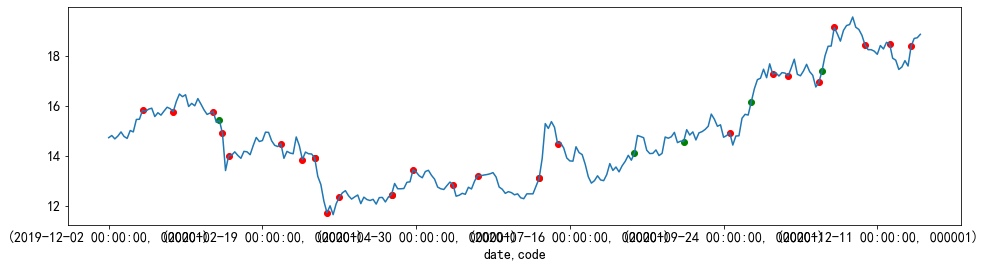

In [22]:
# tst = data.loc[(slice(None),'002352'),'earnings_yield']
# stock_df = load_cache('all_train_qfq',cache_type=CACHE_TYPE.STOCK).sort_index()

##例例例例例例例例例例~~~~~~~~~~~~~~~~~~~~~~~~~~

# import sys
# import os 
# module_path = os.path.abspath(os.path.join('..')) 
# if module_path not in sys.path: 
#     sys.path.append(module_path)
# import tools.Sample_Tools as smpl 
import matplotlib.pyplot as plt

# stock_df = smpl.get_data(['000001','600688'], start='2000-01-01', end='2023-01-01').to_qfq().data
import QUANTAXIS as QA
stock_df = QA.QA_fetch_stock_day_adv(['000001','600688'], start='2000-01-01', end='2023-01-01').to_qfq().data
tst = stock_df.loc[(slice('2019-12','2020-12'),'000001'),'close']
tst.plot(figsize=(16, 4))

# 原始数据不被认为是非金融时序。可以用在处理过的因子上。
change1=ICSS(tst,for_financial=False)
plt.scatter(change1,tst.iloc[change1],color='b')

# # 按照金融时序数据的假设来
change2=ICSS(tst,for_financial=True)
plt.scatter(change2,tst.iloc[change2],color='g')

# # 差分金融时序
change3=ICSS(np.log(tst).diff(1).fillna(0),for_financial=True)
plt.scatter(change3,tst.iloc[change3],color='r')


